# Lab 2: Feature Engineering & Selection

In this lab, we work on feature engineering. Feature engineering is the process of determining which features to include in your model, explained further below. The question we will eventually have our model try and answer is:

*What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. In the next notebook, we will formalize this research question as a machine learning task. Our machine learning task will be to predict the loan amount that a borrower requests from KIVA using all the features we explore in this notebook.

**What is feature engineering?**

When we try to think of features that will predict loan_amount, we are doing feature engineering. We may not end up using all the features we create, but the process is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

Here's a look ahead at what we'll be doing in this notebook: 

1. Load data and packages 

2. Feature engineering and selection:
- borrower features
- loan features
- partner features

In [337]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
from bs4 import BeautifulSoup
import re as re
import types
import seaborn as sns
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

import matplotlib.pyplot as plt
import time
plt.style.use('bmh') 

#package for location features
# If you do not already have this package, run pip install geopy from your terminal.
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [338]:
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [339]:
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 140)
pd.set_option('expand_frame_repr', True)

<b>NOTE:</b> Don't forget to update the name below with your own. 

In [340]:
# Read in data
data_path = 'C://Users/JANE_DOE/Desktop/intro_course_data_science_for_good/data'
df = pd.read_csv(data_path+'df_module_2.csv', low_memory=False)

In [341]:
len(df.index)

118316

## 2: Loan features

Next we create features related to the conditions surrounding each loan posting that we believe may drive loan amount.

## Sector and Activity

We know from our exploratory analysis in the last lesson that sector and activity are both important drivers of loan amount. We will be including both of these in our linear regression.

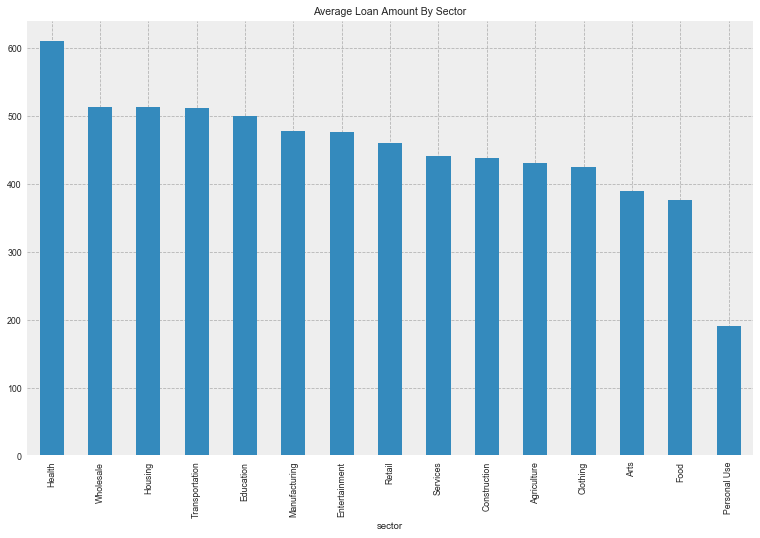

In [631]:
df[df['borrower_count'] == 1].groupby('sector')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Sector", figsize=(13, 8))

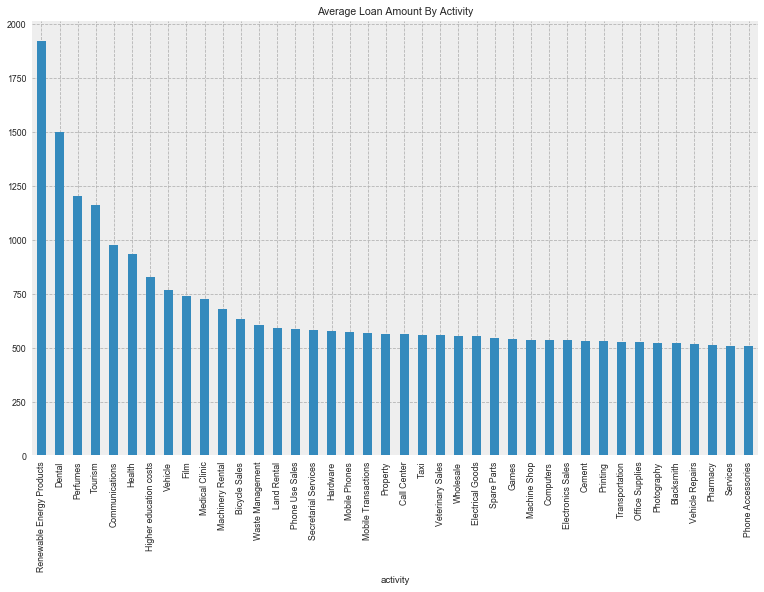

In [632]:
df[df['borrower_count'] == 1].groupby('activity')['loan_amount'].mean().nlargest(40).plot(kind="bar", title="Average Loan Amount By Activity", figsize=(13, 8))

## Time features

In order to leverage time features, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them.

In [633]:
##  posted date features
df['posted_datetime'] = pd.to_datetime(df['posted_datetime'])
df['posted_year']=df['posted_datetime'].dt.year
df['posted_month']=df['posted_datetime'].dt.month

In [634]:
## Time to fund is the funded date minus the posted date
## we add these fields because the homework question in the next notebook involves predicting time to fund
df['time_to_fund'] =pd.to_datetime(df['funded_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_fund'] = df.time_to_fund.dt.days
s = df.time_to_fund.dt.seconds
df['hours_to_fund'], s= divmod(s, 3600)

In [635]:
# expiration date features
## Time to expiration is the expiration date minus the Posted Date
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_datetime'])
df['time_to_expire_datetime'] =df['planned_expiration_datetime'] - df['posted_datetime']
df['days_to_expire'] = df.time_to_expire_datetime.dt.days

In [636]:
## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_dispersal'] =pd.to_datetime(df['dispursal_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_dispersal'] = df.time_to_dispersal.dt.days

Since we are trying to understand what drives loan amount, we restrict (as we have done in all charts so far) our dataset to loans with a single borrower. In the chart below, we plot the average loan amount by year and see that the average loan amount goes down year over year.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

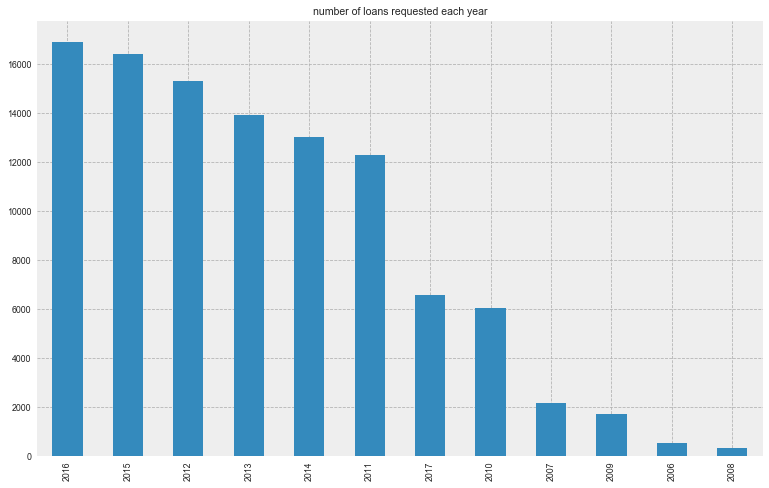

In [638]:
df[df['borrower_count'] == 1]['posted_year'].value_counts().plot(kind="bar", figsize=(13, 8),title='number of loans requested each year')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

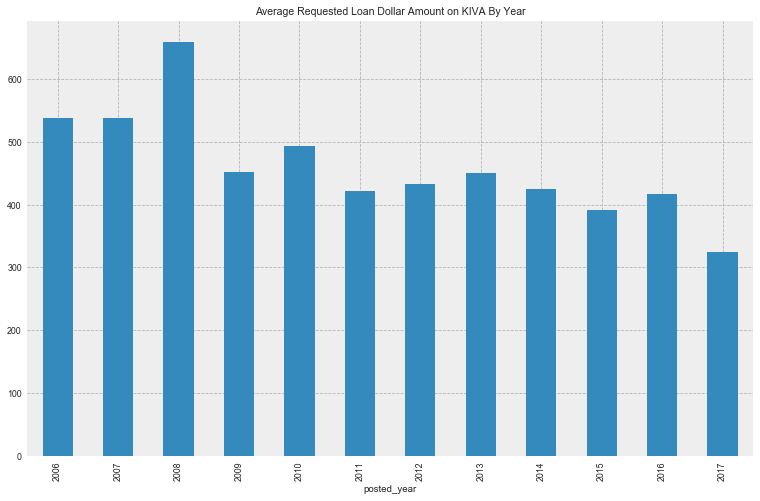

In [639]:
df[df['borrower_count'] == 1].groupby('posted_year')['loan_amount'].mean().plot(kind="bar", figsize=(13, 8),title='Average Requested Loan Dollar Amount on KIVA By Year')
plt.xticks(rotation=90)

Why does loan amount requested go down? One possibility is that partners learn from experience what does and does not get funded. Remember our exploratory analsysis showed expired loans tended to be much larger on average. Perhaps lenders figured out their odds of success go up if they request lower amounts.

### Do loans amounts spike at certain point during the year?

It might be interesting to also look at loan size by month. It is very possible that end-of-year celebrations or the beginning of the school year in January put a strain on household budgets and result in higher loan amount requests.

We can see below that the loan amount is on average higher in **November, December and February**. This seems to strengthen our hypothesis that loan amount is driven somewhat by seasonal preassures.

As always, we follow-up with a box plot. This helps us understand the variance in loan amount between months. The results confirm our understanding that the distribution varies by month, we will include this feature.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

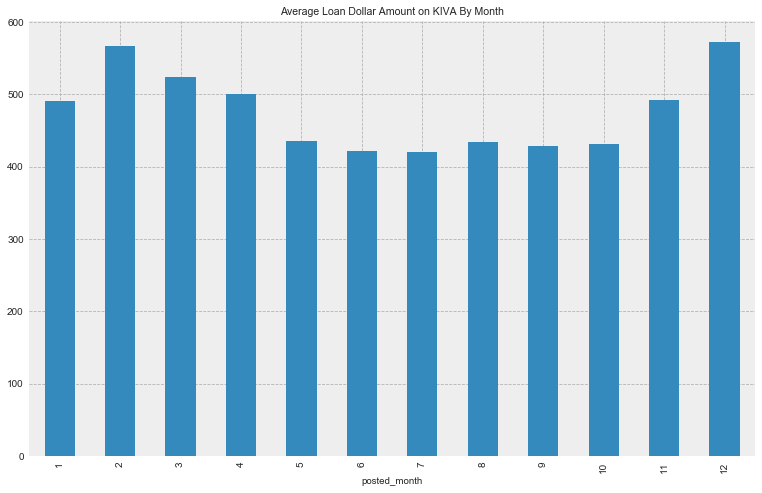

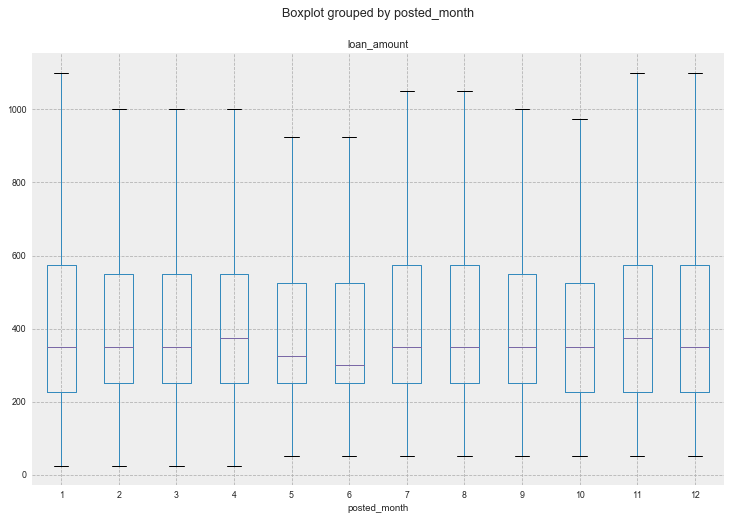

In [640]:
df.groupby('posted_month')['loan_amount'].mean().plot(kind="bar", figsize=(13, 8), fontsize=10,title='Average Loan Dollar Amount on KIVA By Month')
plt.xticks(rotation=90)

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='posted_month', showfliers=False, figsize=(12,8))

In [641]:
df['terms.loss_liability.currency_exchange_coverage_rate'].value_counts()

0.1    88998
0.2    25352
Name: terms.loss_liability.currency_exchange_coverage_rate, dtype: int64

## Days to fund

The appears to be a weak positive relationship between days to fund and the loan amount. We should keep this feature in mind.

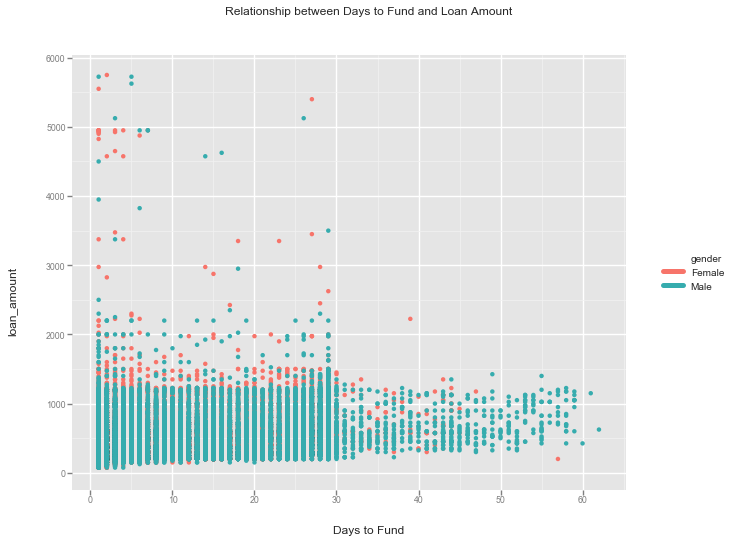

<ggplot: (547943926)>

In [642]:
ggplot(df[(df['borrower_count'] == 1) &(df['days_to_fund']>0)], aes(x = 'days_to_fund', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Days to Fund and Loan Amount") + xlab("Days to Fund") + ylab("loan_amount")

There are some erroneous values in the days_to_fund feature which must the results of an incorrect posted or funded date. Let's take a look at these examples.

In [643]:
len(df)

118199

In [644]:
df['days_to_fund'].max()
df['days_to_fund'].min()

62.0

-442.0

In [645]:
# There are some erroneous values in the days_to_fund feature so lets remove 
negative_days_to_fund=df[df['days_to_fund'] < 0].sample(20)

By taking a closer look, we see that many of these loans are from 2006.

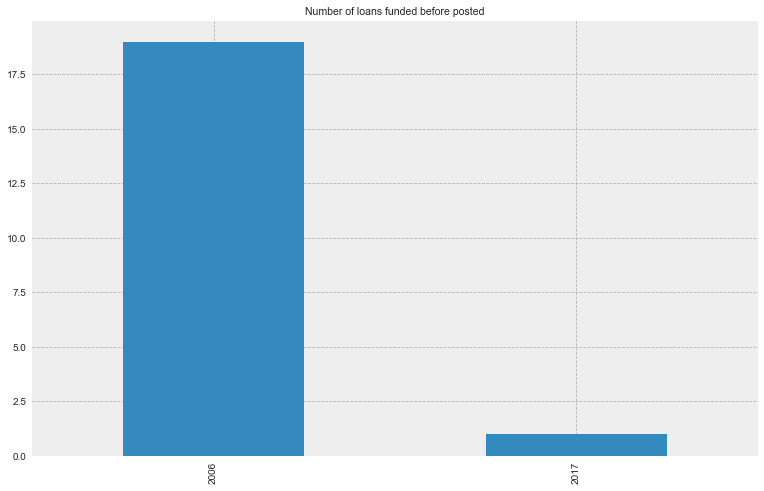

In [646]:
negative_days_to_fund['posted_year'].value_counts().plot(kind="bar", figsize=(13, 8), fontsize=10,title='Number of loans funded before posted')                             
                              

We also know anecdotally from meeting the Kiva team that there was not much oversight of partners before 2008. This was when Kiva set up a team in Nairobi. Let's keep all of this is mind for when we run the model. We will try restricting to different periods of time and see how that affects our model fit. 

## 3: Partner Features

Recall from our exploratory analysis that KIVA relies heavily on it's partners to dispense loans in Kenya. In fact, only a negligable amount of loans are not associated with a partner. It is clearly important to take into account partner dynamics as we continue with our feature engineering.

## Number of countries partners are in

We can find the number of partners by doing a lookup of the number of times name appears in the partner_countries field. this appears once for each country.

In [648]:
df['num_partner_countries'] = df['partner_countries'].apply(lambda x: x.count('name'))

In [649]:
df['num_partner_countries'].value_counts()

1    106537
2     11372
4       284
5         6
Name: num_partner_countries, dtype: int64

In [650]:
df['more_one_partner_country'] = np.where(df['num_partner_countries']==1, 0, 1)

In [651]:
df['more_one_partner_country'].value_counts()

0    106537
1     11662
Name: more_one_partner_country, dtype: int64

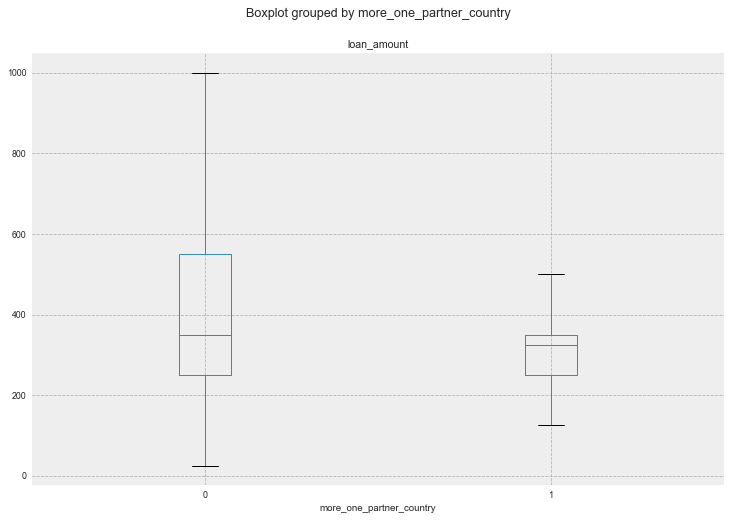

In [652]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='more_one_partner_country', showfliers=False, figsize=(12,8))

## Partner Profitability and Financial Stability

How do partners affect loan amount? Does a partner's profitability have anything to do with the loan amount issued. Firstly, we evaluate a potential data issue where some partners have profitability below 0.

In [653]:
df[df['partner_profitability']<0].head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,...,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund,gender,widowed,kids,elderly,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,parent,married,age,children_1,children_2,children_int_1,children_int_2,age_int,children_int,age_bucket,location,location_detail,location_str,county,county_messy,province_messy,capital_messy,province,province_capital,capital,county_1,county_2,province_1,province_final,capital_final,county_3,county_4,county_final,country_2,num_male,num_female,pct_female,days_to_fund,hours_to_fund,time_to_expire_datetime,days_to_expire,time_to_dispersal,days_to_dispersal,num_partner_countries,more_one_partner_country
2,2,2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,"[{'due_date': '2017-05-14T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...","['Green', 'Earth Day Campaign']",Julie Keaton,892591.0,to buy a solar lantern.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,...,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:30:04,NaN,2017-06-08 00:30:03,2017-04-28 07:00:00,1,2017-04-28,2017,5,NaT,Female,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,NaN,NaN,NaN,NaN,NaN,29.558037,0.0,NaN,eldoret kenya,"Eldoret, Uasin Gishu, Kenya","eldoret, uasin gishu,",uasin,NaN,NaN,eldoret,rift valley,eldoret,eldoret,uasin,NaN,rift valley,rift valley,eldoret,uasin,uasin,uasin,uasin,0,1,100.0,NaN,NaN,29 days 23:59:59,29.0,-11 days +06:29:56,-11,1,0
4,4,4,4,Farming,0.0,False,"[{'first_name': 'Alice', 'last_name': '', 'gen...",NaN,['en'],Alice (the woman pictured above in her small s...,NaN,NaN,NaN,0,NaN,1291518,2515975,1,0,0,0,400,Kenya,KE,town,1 38,point,Nandi Hills,Alice,156.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,[{'name': '#Woman Owned Biz'}],40000.0,KES,2017-05-27T07:00:00Z,400,"[{'due_d

This is strange. We are not sure why there would be partners with profitability below 0. We plan to ask the KIVA team but until we get an answer we will focus on partner delinquency.

Below we see that partner deliquency appears to have postive relationship with loan amount. This suggests that some partners may be requesting too high a loan amount, and are unable to pay it back. Instead, let's look at some other features that may drive loan amount. 

Two other patner features that are interesting are partner delinquency rate and the number of partner loans posted.

## Delinquency rate

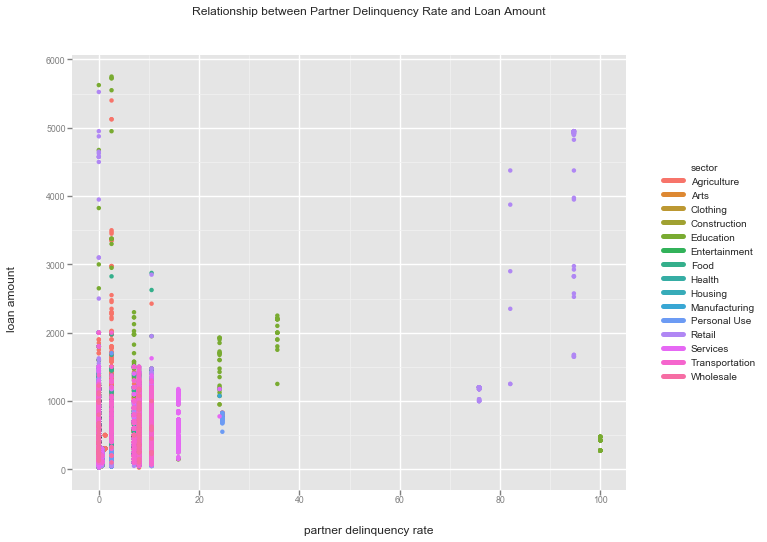

<ggplot: (-9223372036306837574)>

In [654]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_delinquency_rate', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Partner Delinquency Rate and Loan Amount") + xlab("partner delinquency rate") + ylab("loan amount")

We can see from the chart above that there does in fact appear to be a positive relationship between partner delinquency rate and loan amount. Additionally, it appear certain sectors (like construction and retail) have a higher risk of delinquency. Good to know! We will be including this feature in our model.

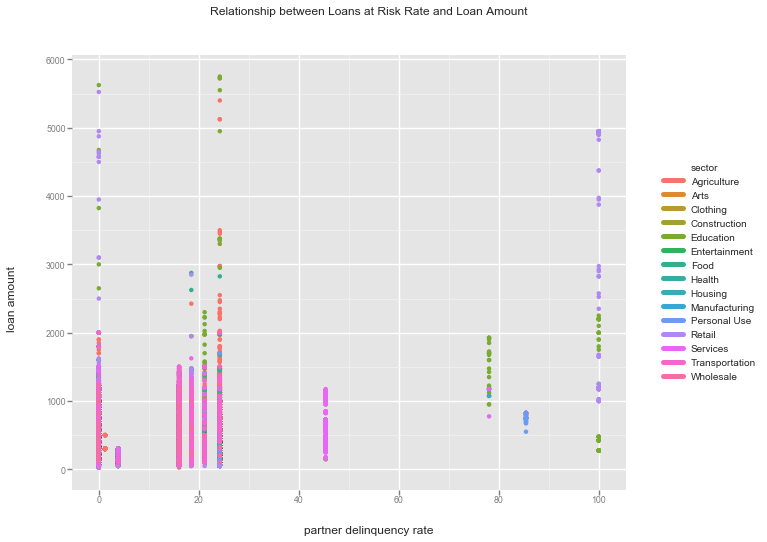

<ggplot: (-9223372036273066380)>

In [655]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_loans_at_risk_rate', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Loans at Risk Rate and Loan Amount") + xlab("partner delinquency rate") + ylab("loan amount")

## Number of Loans Posted

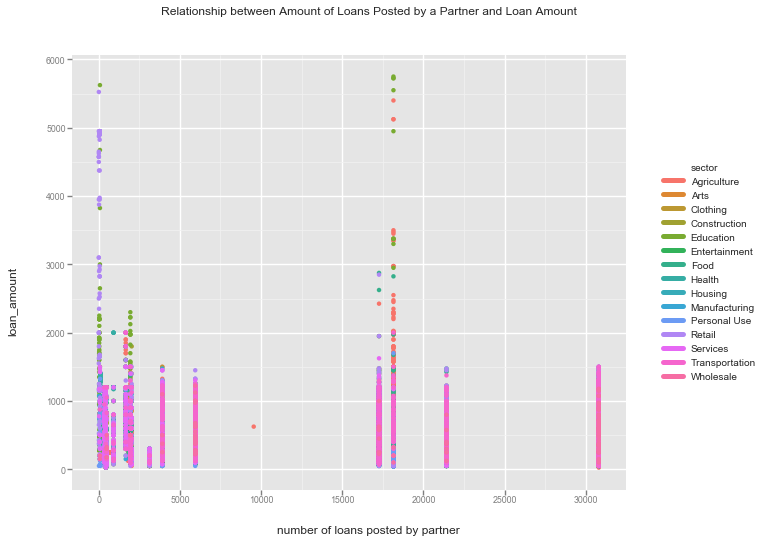

<ggplot: (-9223372036272139225)>

In [656]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_loans_posted', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Amount of Loans Posted by a Partner and Loan Amount") + xlab("number of loans posted by partner") + ylab("loan_amount")

The feature does seem initally promising, albeit weak. It suggests that as partner loans posted goes up the loan amont goes down. It would be interesting to try this in our model, but we should be aware of a potential issue with this feature.


The issue, as we can see in the chart above is that partner_loans_posted ends up serving as a unique identifier for a partner_id. We must make sure not to include both partner_loans_posted and partner_id because they are probably highly correlated. Ask in slack if you don't understand why this is true.

## Loan Concentration

(array([], dtype=float64), <a list of 0 Text xticklabel objects>)

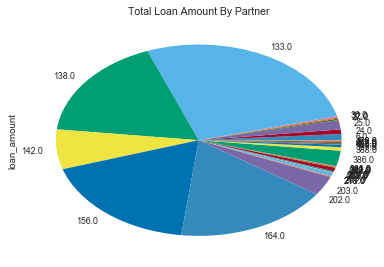

In [657]:
df[(df['borrower_count'] == 1)].groupby('partner_id')['loan_amount'].sum().plot(kind="pie", title='Total Loan Amount By Partner')
plt.xticks(rotation=90)

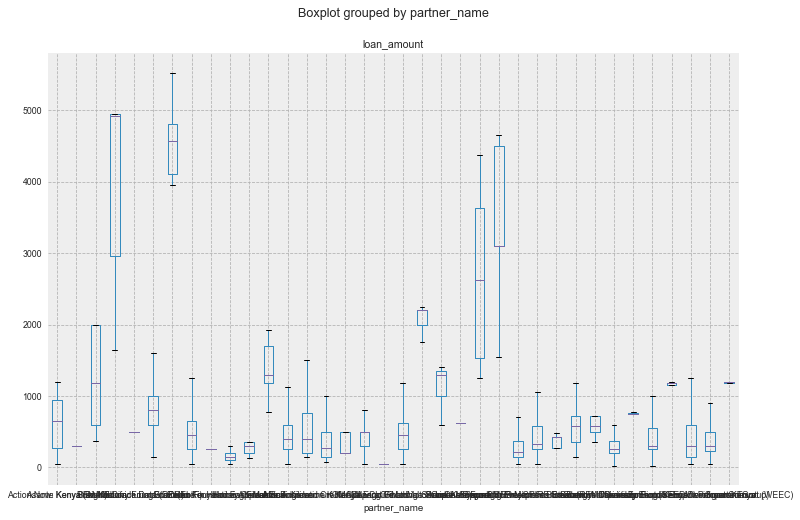

In [658]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='partner_name', showfliers=False, figsize=(12,8))

In [659]:
def top_partners_id(x, col):
    # Find the top fifteen responses
    partners_id = [] 
    col_vals = df[col].value_counts().index[:8]
    print(col_vals)
    for p in x:
        if p in col_vals:
            partners_id.append(p)
        else:
            if isinstance(p, str):
                partners_id.append('Other')
            else:
                partners_id.append(1.0)
    return partners_id

df['top_partners'] = top_partners_id(df['partner_name'], 'partner_name')
df['top_partner_id'] = top_partners_id(df['partner_id'], 'partner_id')

df['top_partner_id'].dtype
df['top_partners'].dtype

Index(['VisionFund Kenya', 'Yehu Microfinance Trust', 'SMEP Microfinance Bank',
       'Juhudi Kilimo', 'One Acre Fund', 'Faulu Kenya',
       'Hand in Hand Eastern Africa', 'Milango Financial Services'],
      dtype='object')
Float64Index([133.0, 164.0, 138.0, 156.0, 202.0, 142.0, 388.0, 203.0], dtype='float64')


dtype('float64')

dtype('O')

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

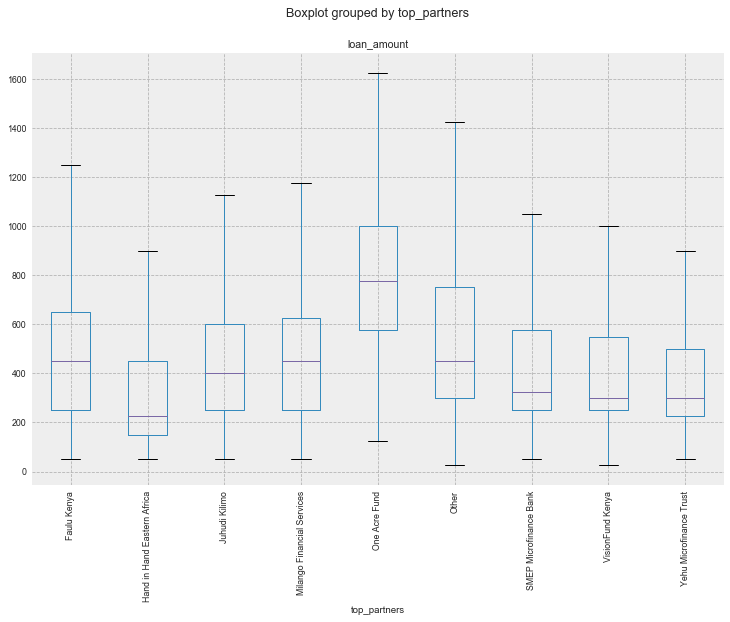

In [661]:
df.boxplot(column='loan_amount', by='top_partners', showfliers=False, figsize=(12,8))
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

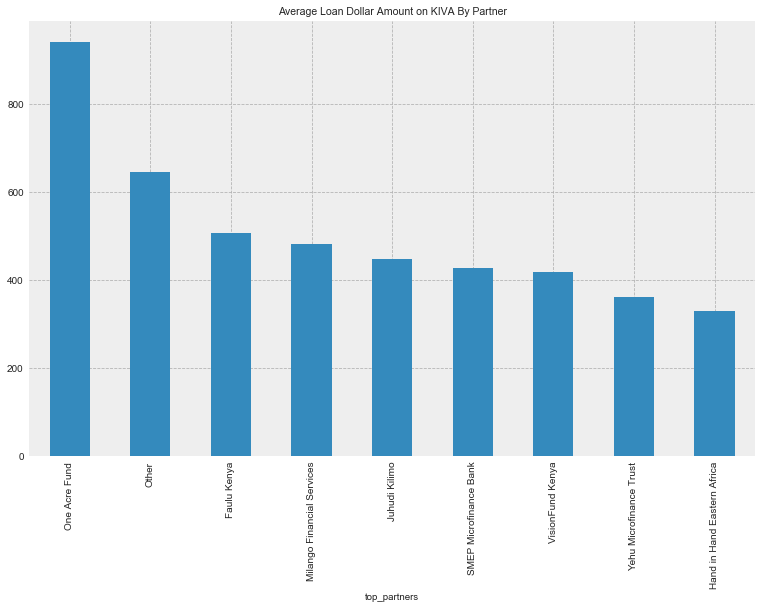

In [662]:
df.groupby('top_partners')['loan_amount'].mean().nlargest(20).plot(kind="bar", figsize=(13, 8), fontsize=10,title='Average Loan Dollar Amount on KIVA By Partner')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

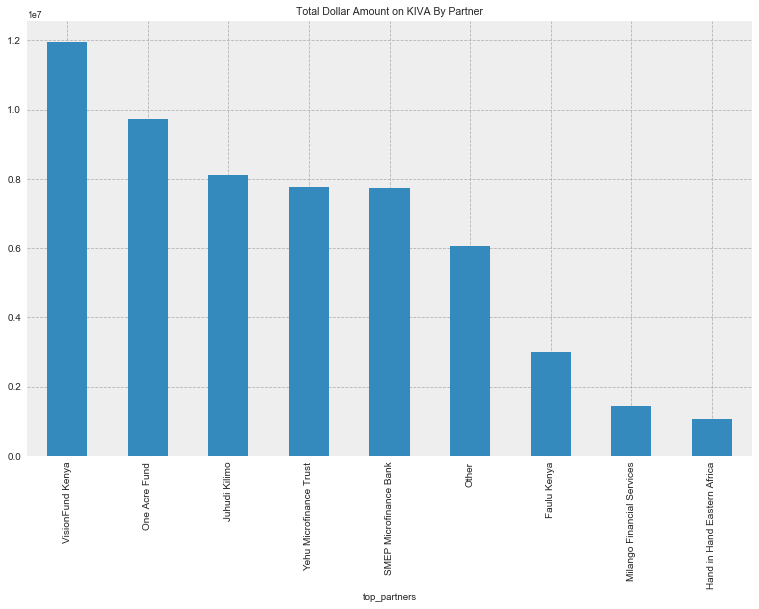

In [663]:
df.groupby('top_partners')['loan_amount'].sum().nlargest(20).plot(kind="bar", figsize=(13, 8), fontsize=10,title='Total Dollar Amount on KIVA By Partner')
plt.xticks(rotation=90)

We can also see below that the top partners have variance in their distribution of loan amount. Interesting - this could be caused by the sectors they heavily lend to or by where they are located. What are some other reasons you can think of for this difference?

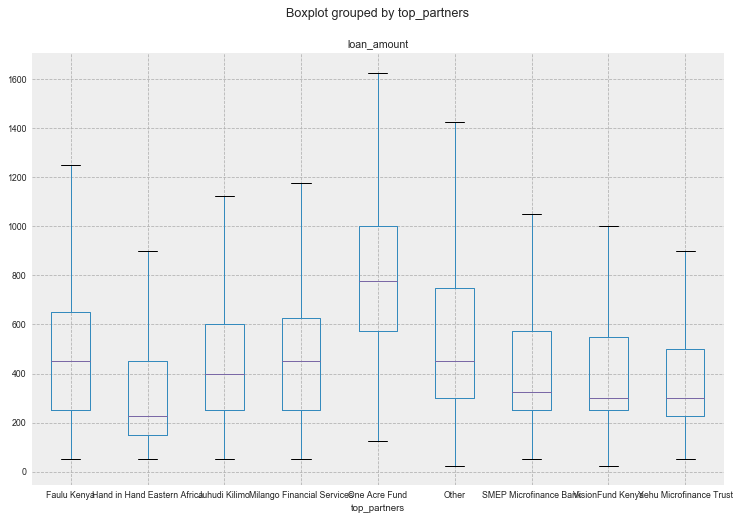

In [664]:
df.boxplot(column='loan_amount', by='top_partners', showfliers=False, figsize=(12,8))

We know from Kiva that an exploratory partner who does not have a proven track record can be tested using a seed sum of $50,000. Let's create a boolean feature for exploratory partner in case we want to remove or otherwise treat these partners differently.

In [665]:
partner_dollar_amount = pd.DataFrame(df[(df['borrower_count'] == 1)].groupby(['partner_name','posted_year']).sum()['loan_amount'])
partner_dollar_amount.columns = ['partner_dollar_amount']
df = df.merge(partner_dollar_amount, left_on=['partner_name','posted_year'], right_index=True, how='outer')

In [666]:
df['exploratory_partner']=np.where(df['partner_dollar_amount']>50000,0,1)

In [667]:
df[(df['borrower_count'] == 1)]['exploratory_partner'].value_counts()

0    103765
1      1442
Name: exploratory_partner, dtype: int64

## Abridge data set

We have been doing a lot of feature engineering work. Every additional feature we create takes up space. Let's do some cleanup of features we know we will not be using so that we can save storage space. We will call this dataframe abridged.

In [668]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,...,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund,gender,widowed,kids,elderly,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,parent,married,age,children_1,children_2,children_int_1,children_int_2,age_int,children_int,age_bucket,location,location_detail,location_str,county,county_messy,province_messy,capital_messy,province,province_capital,capital,county_1,county_2,province_1,province_final,capital_final,county_3,county_4,county_final,country_2,num_male,num_female,pct_female,days_to_fund,hours_to_fund,time_to_expire_datetime,days_to_expire,time_to_dispersal,days_to_dispersal,num_partner_countries,more_one_partner_country,top_partners,top_partner_id,partner_dollar_amount,exploratory_partner
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,...,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaT,Female,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,44 years,NaN,6 children,NaN,6.0,44.0,6.0,"(40, 50]",litein kenya,"Litein, Kericho, Kenya","litein, kericho,",kericho,NaN,NaN,NaN,rift valley,kericho,kericho,kericho,kericho,rift valley,rift valley,kericho,kericho,kericho,kericho,kericho,0,1,100.0,NaN,NaN,30 days,30.0,-36 days +06:19:57,-36,1,0,Other,1.0,253750.0,0
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'am

In [673]:
df_abridged=cols = df[[
    'activity','borrowers', 'description.texts.en','funded_amount','funded_date', 
    'loan_amount', 'loan_amount','name','partner_id','planned_expiration_date','posted_date',
    'sector','status','tags','terms.loss_liability.currency_exchange_coverage_rate','terms.repayment_term',
    'terms.scheduled_payments','translator.byline','use','borrower_count','partner_delinquency_rate',
    'partner_loans_posted','partner_loans_at_risk_rate','partner_delinquency_rate','partner_status','partner_name','posted_datetime',
    'planned_expiration_datetime','dispursal_datetime','posted_year','posted_month','time_to_fund',
    'gender','kids','num_tags','tag_#Woman Owned Biz','tag_#Repeat Borrower','tag_#Schooling','parent','married',
    'age_int','children_int','age_bucket','county','province','capital','pct_female','num_partner_countries','more_one_partner_country',
    'top_partner_id','partner_dollar_amount','exploratory_partner','days_to_fund','hours_to_fund','top_partners']]

In [674]:
df_abridged.to_csv(data_path+'df_abridged.csv')

## Next Steps

Next, we will take our data and will be evaluating the feature performance at predicting loan amount requested using:
- a linear regression model
- a regression tree
- a bagging algorithm
- a random forest